## Описание проекта.Мэтчинг
<br><br>__Задача__:
- разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;
- оценить качество алгоритма по метрике accuracy@5.

__Данные которые у нас есть__:
- base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

- train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

- validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

- validation_answer.csv - правильные ответы к предыдущему файлу

    __План работы__:
   <br><br> - Загрузка библиотек.
    <br><br>- Ознакомление с данными и их предобработка.
    <br><br>- Базовые модели.
    <br><br>- Вычисление оптимального кол-ва кластеров.
    <br><br>- Тесты параметров `FAISS`.
   

# 1. Загрузка библиотек.

In [56]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
import missingno as msno
import faiss
from scipy import stats
from scipy.stats import shapiro


In [57]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [58]:
pip install faiss-cpu

Note: you may need to restart the kernel to use updated packages.


# 2. Ознакомление с данными и их предобработка.

In [59]:
base = pd.read_csv('/home/anna/Masterskaya2/base.csv',index_col=0)


# ▶ base.
 base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

In [60]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


In [61]:
base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [62]:
base.dtypes.value_counts()

float64    72
dtype: int64

In [63]:
base.isna().sum()

0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64

In [64]:
sns.set()

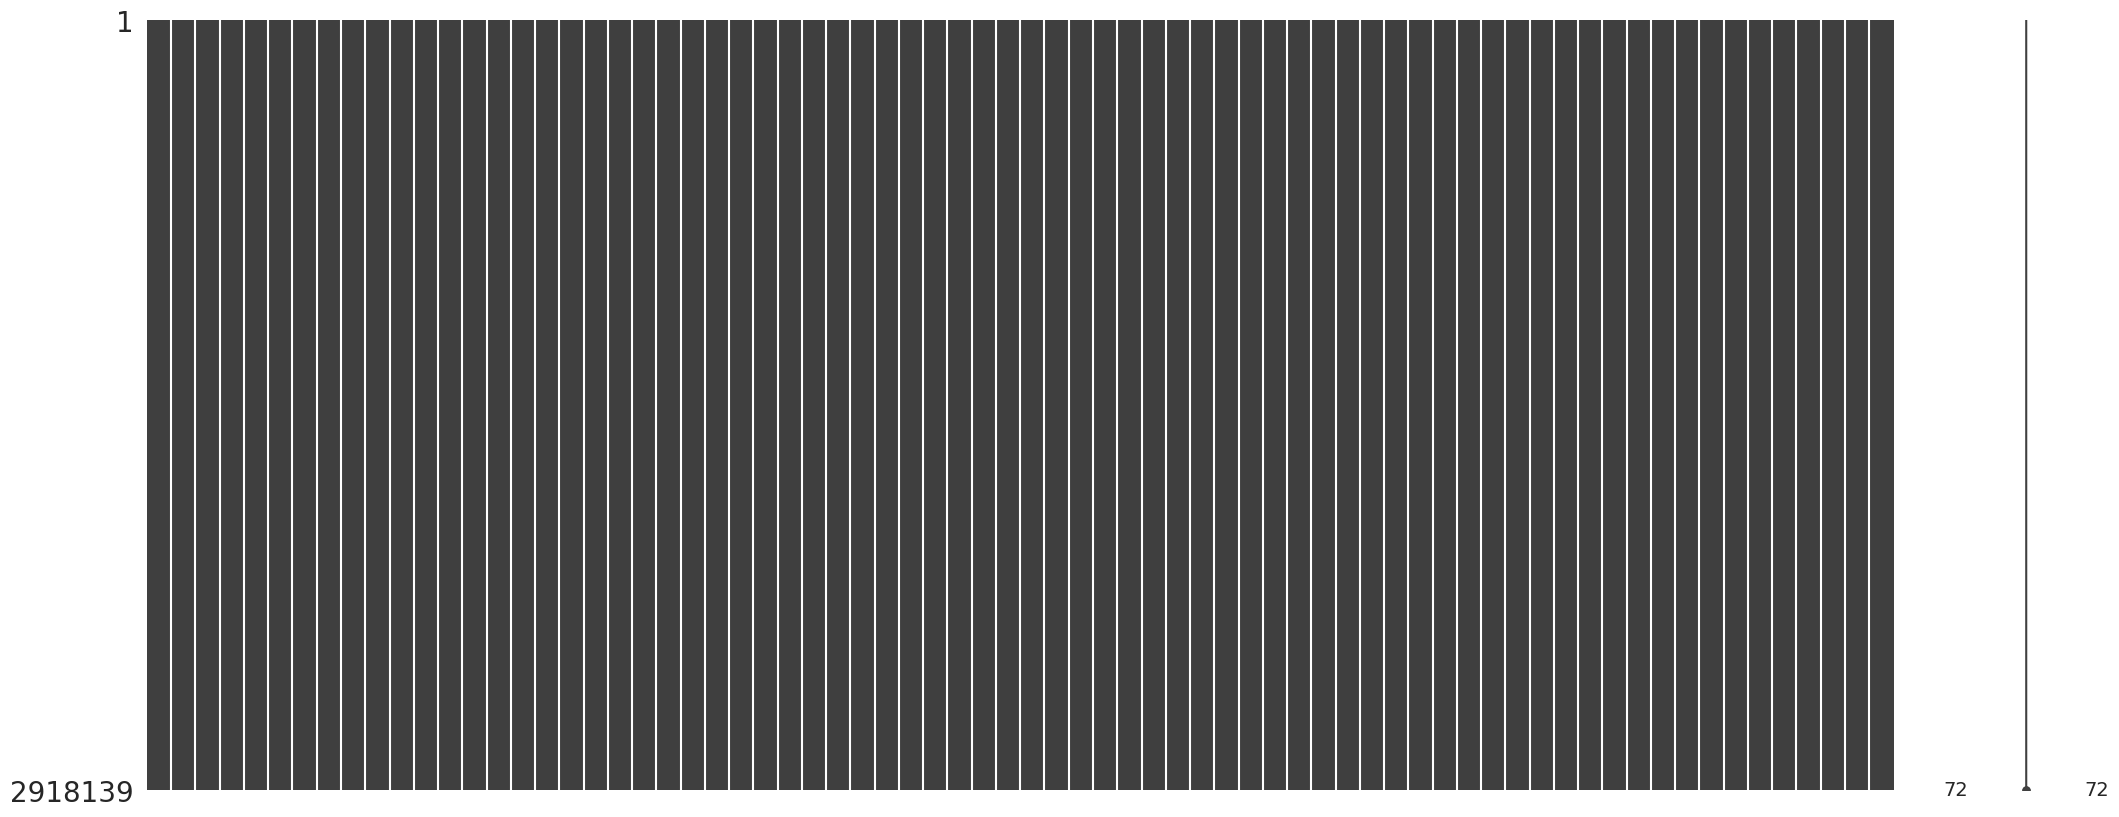

In [65]:
msno.matrix(base);

Матрица пропущенных значений (функция msno.matrix()). Решила поэксперементировать и посмотреть как выглядит. ПРопущенных значений у нас нет .

In [66]:
base[base.duplicated()]

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,


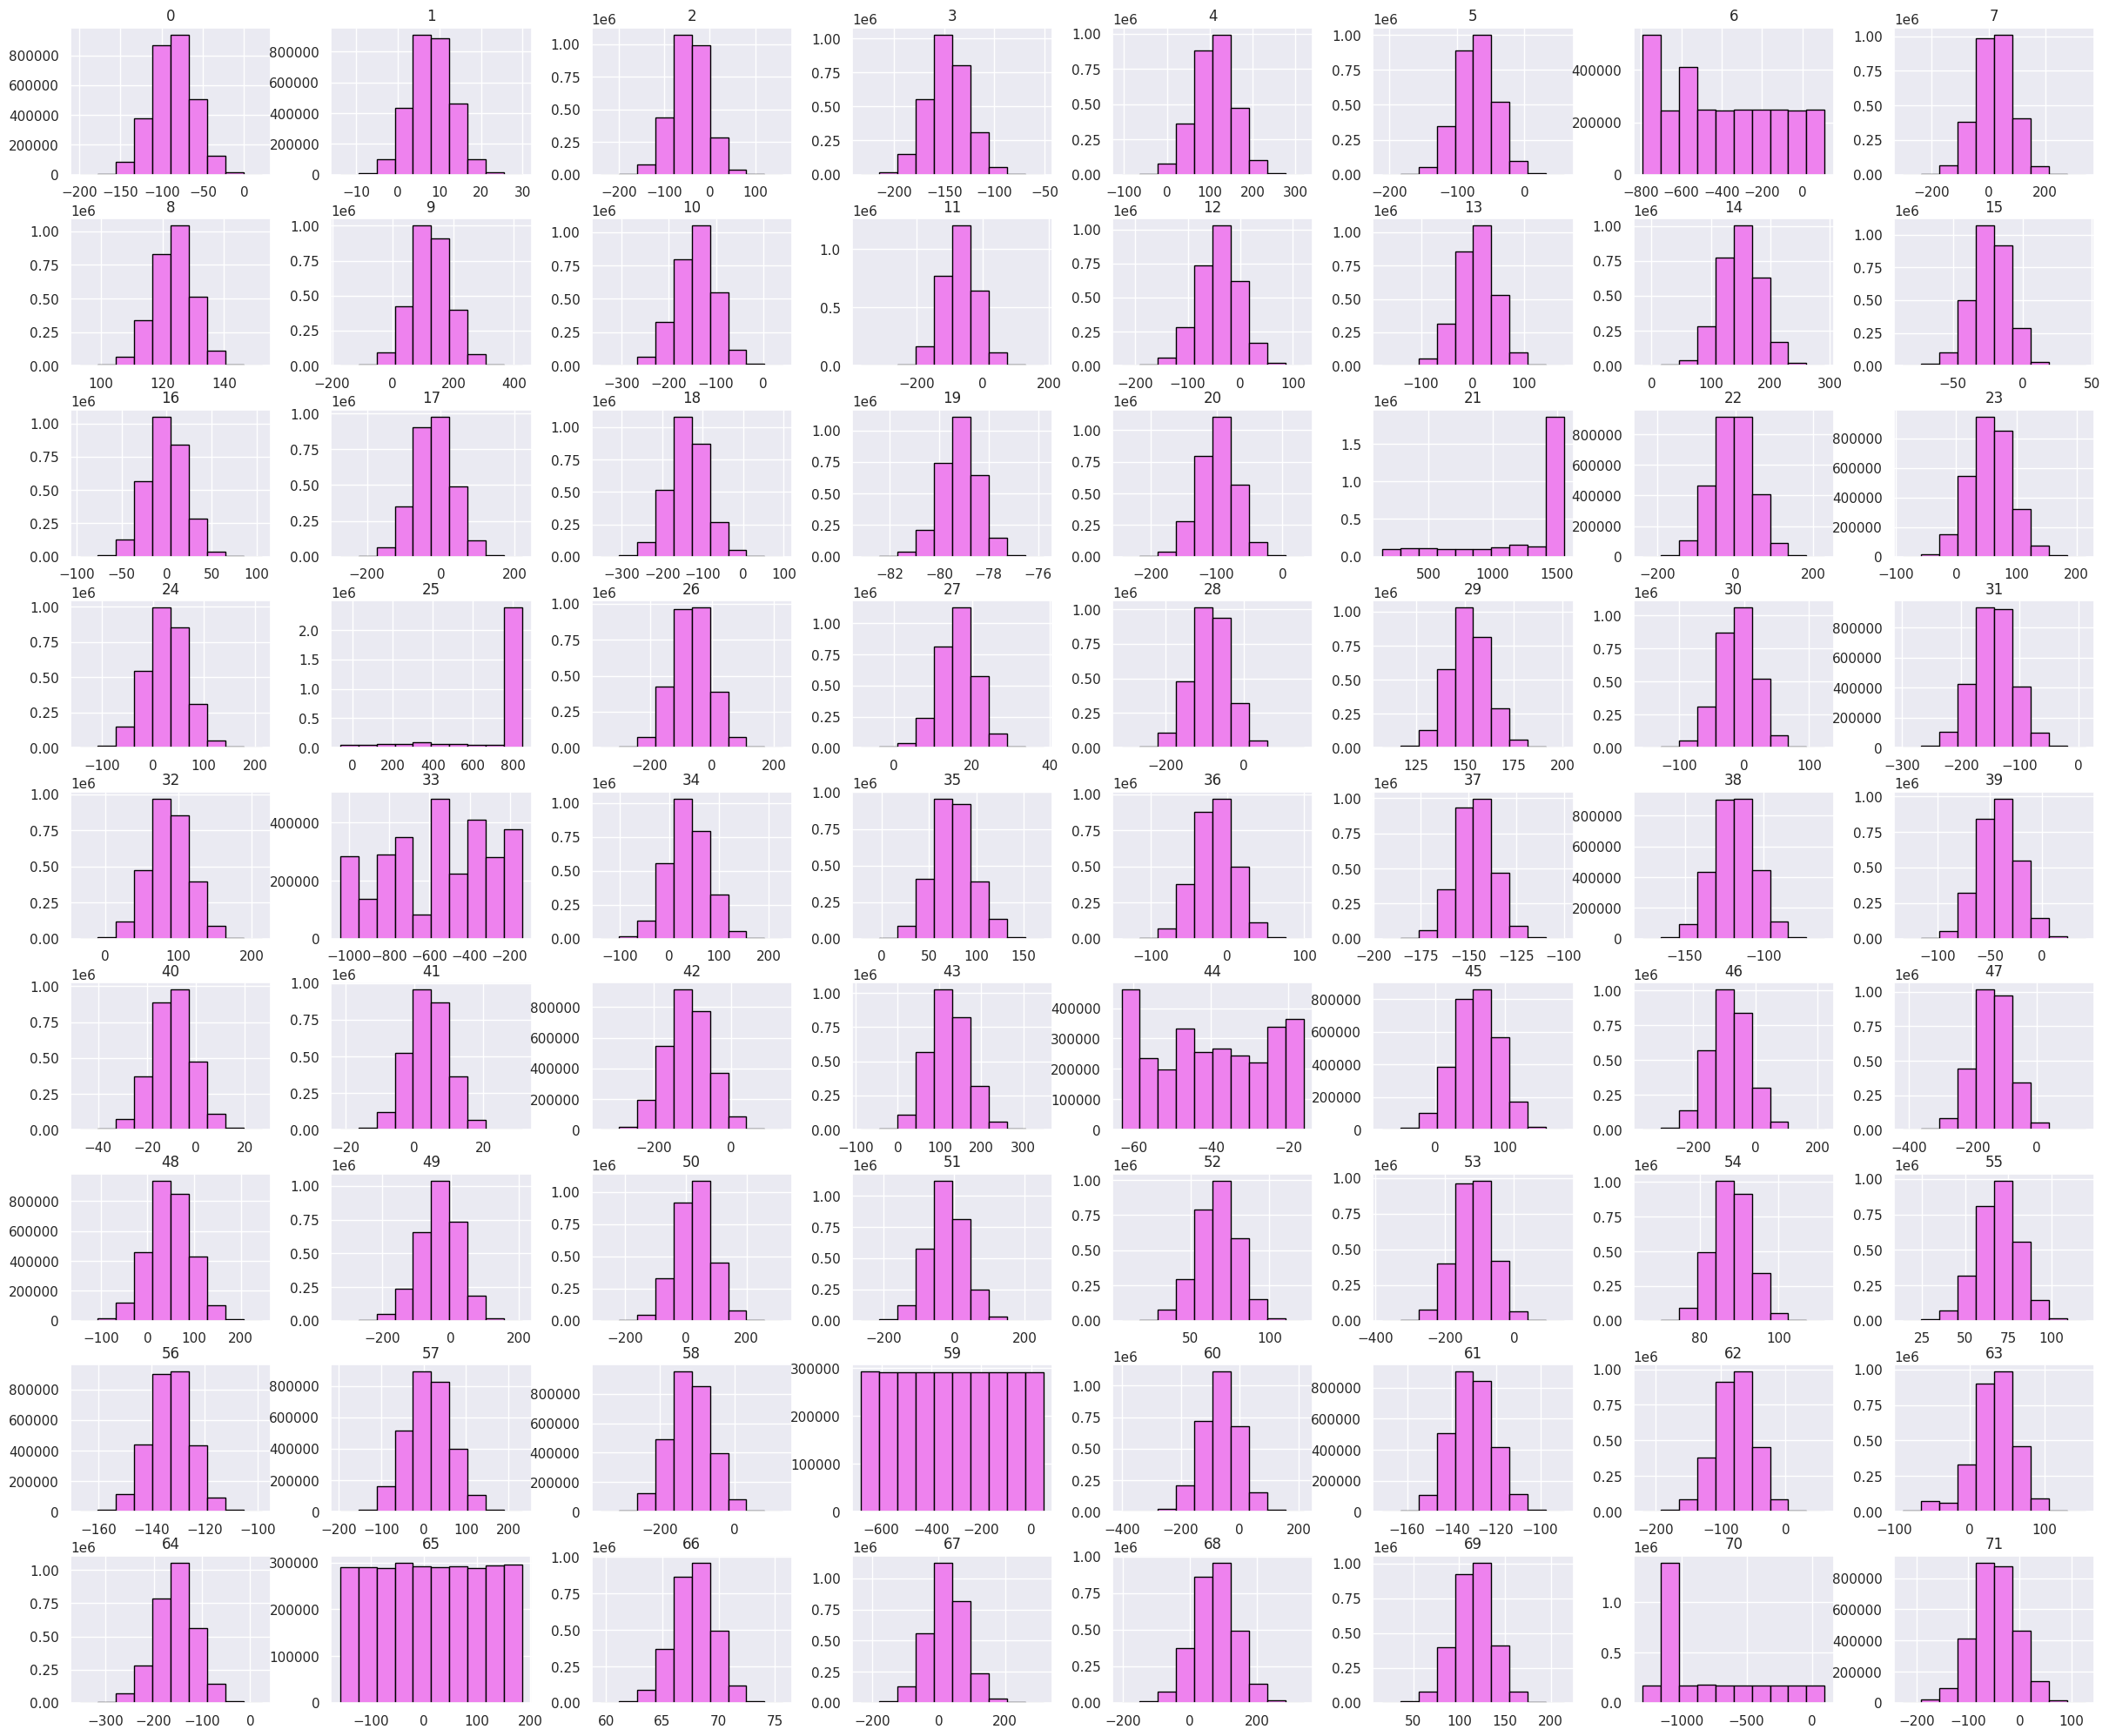

In [67]:
base.hist(figsize = (30,25),color = 'violet', edgecolor = 'black'); 

Построили гистограмму и возникают вопросы по столбцам : 6,21,25,33,44,59,65,70. 
Остальные имеют нормальное распределение. 

Посмотрим на них поближе.

In [68]:
base['6'].value_counts(normalize=True).sort_values(ascending=False)* 100

-759.626065    9.838119
-530.124724    5.647949
-175.047853    0.127033
-92.055125     0.124120
-750.151074    0.091120
                 ...   
-384.359419    0.000034
-490.546973    0.000034
-287.521648    0.000034
-192.942499    0.000034
-532.907338    0.000034
Name: 6, Length: 1927620, dtype: float64

In [69]:
base['21'].value_counts(normalize=True).sort_values(ascending=False)* 100

1507.231274    59.214486
1248.126198     1.397603
1342.641120     1.128562
1483.714136     0.804828
1054.205600     0.683689
                 ...    
886.404084      0.000034
1101.904170     0.000034
255.692341      0.000034
342.367500      0.000034
889.961374      0.000034
Name: 21, Length: 715856, dtype: float64

In [70]:
base['25'].value_counts(normalize=True).sort_values(ascending=False)* 100

813.770071    79.626776
366.779583     1.480670
175.595709     0.225658
514.955051     0.045543
701.226241     0.042150
                ...    
712.599115     0.000034
776.222972     0.000034
144.941913     0.000034
209.753875     0.000034
585.357843     0.000034
Name: 25, Length: 328121, dtype: float64

In [71]:
base['33'].value_counts(normalize=True).sort_values(ascending=False)* 100

-529.295053     6.270606
-156.249890     4.258091
-1018.469545    4.166183
-537.183707     3.761404
-481.586956     3.420742
                  ...   
-207.286692     0.000034
-445.827236     0.000034
-673.821574     0.000034
-736.976824     0.000034
-469.273294     0.000034
Name: 33, Length: 4048, dtype: float64

In [72]:
base['44'].value_counts(normalize=True).sort_values(ascending=False)* 100

-61.441417    6.209197
-18.251750    3.321226
-47.166102    1.526212
-16.440254    1.192849
-21.092403    0.965958
                ...   
-54.492942    0.000034
-55.948900    0.000034
-56.618635    0.000034
-24.723822    0.000034
-52.024123    0.000034
Name: 44, Length: 44247, dtype: float64

In [73]:
base['59'].value_counts(normalize=True).sort_values(ascending=False)* 100

-230.403784    0.000069
-13.211805     0.000069
-82.038490     0.000069
-188.534014    0.000069
-651.846315    0.000069
                 ...   
-310.999177    0.000034
-545.781881    0.000034
-634.787442    0.000034
-34.273397     0.000034
-409.243837    0.000034
Name: 59, Length: 2916064, dtype: float64

In [74]:
base['65'].value_counts(normalize=True).sort_values(ascending=False)* 100

-21.533007     0.113703
 181.959582    0.091085
-81.475771     0.081113
 182.446349    0.070696
 130.450168    0.066207
                 ...   
 120.056320    0.000034
 140.786146    0.000034
 143.616043    0.000034
 151.420972    0.000034
-5.081259      0.000034
Name: 65, Length: 2502958, dtype: float64

In [75]:
base['70'].value_counts(normalize=True).sort_values(ascending=False)* 100

-1074.464888    41.923877
-782.676180      0.235321
-597.491204      0.028957
-799.363667      0.005106
-891.219087      0.005072
                  ...    
-240.833508      0.000034
-636.568682      0.000034
-879.196252      0.000034
-709.391291      0.000034
-1073.826170     0.000034
Name: 70, Length: 1573822, dtype: float64

In [76]:
base_p = base[['6','21','25','33','44','59','65','70']]

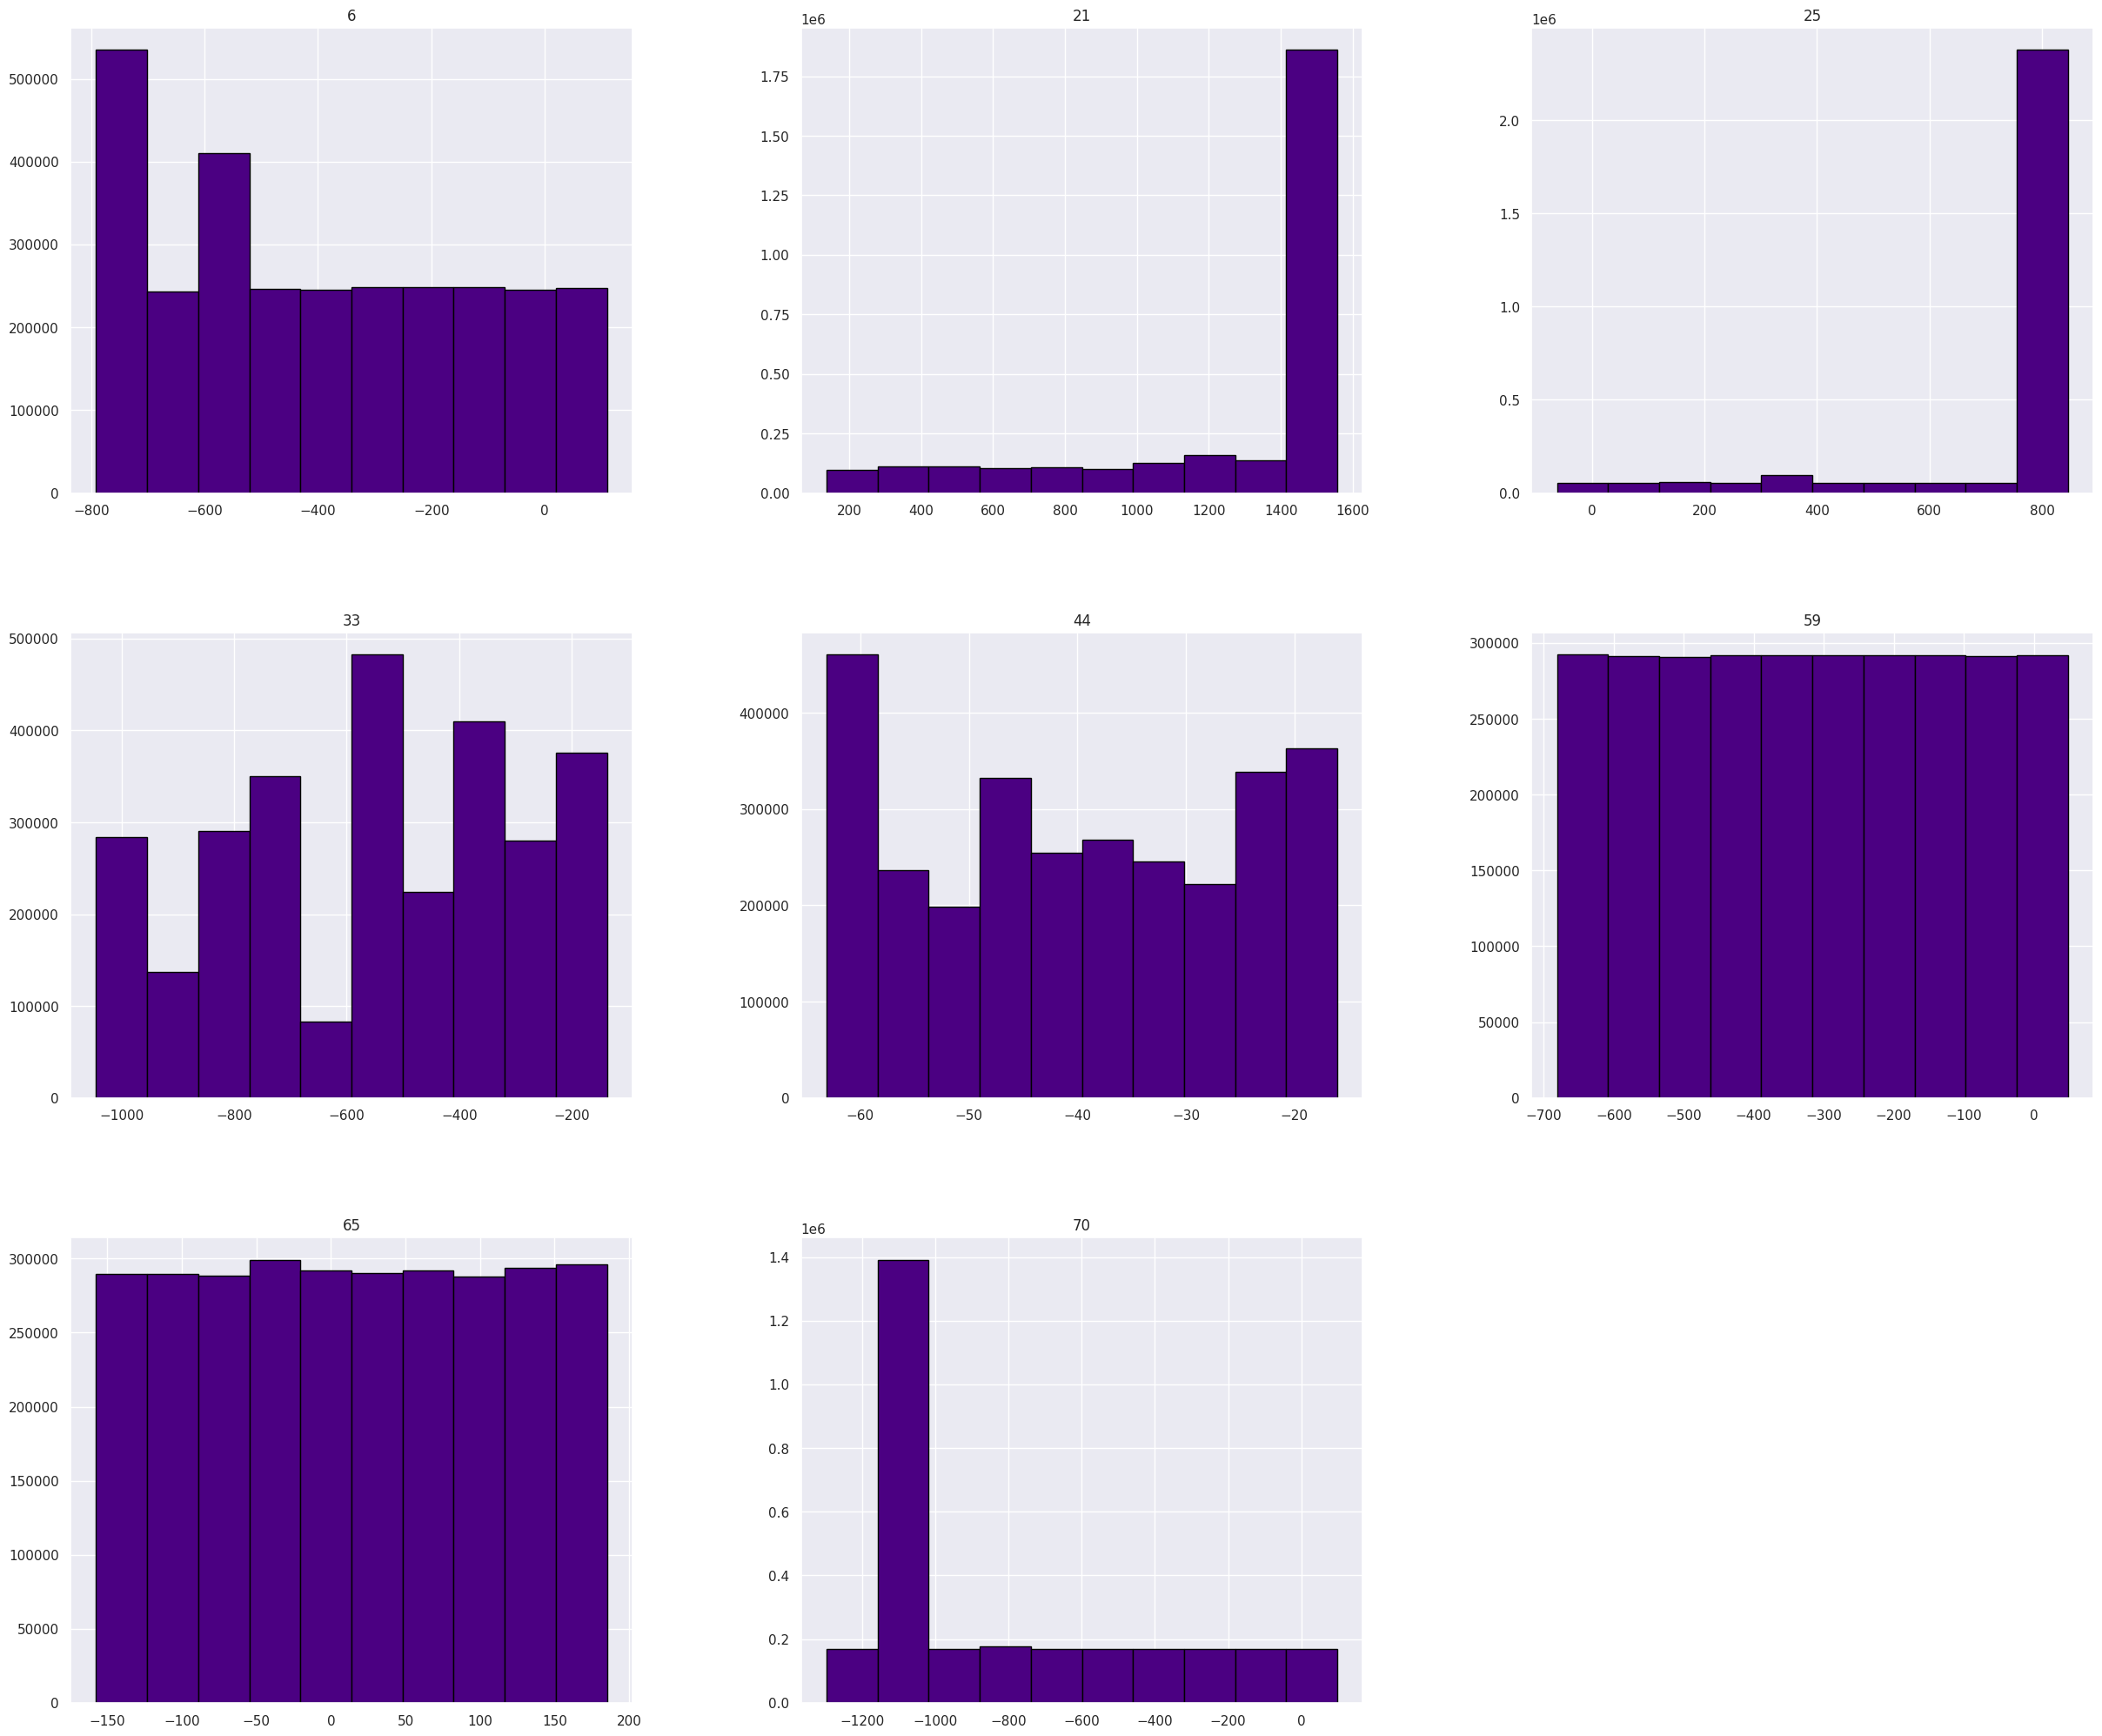

In [77]:
base_p.hist(figsize = (30,25),color = 'indigo', edgecolor = 'black');

<p>base['6']:  У нас есть всплески на данных -759.626065  \   9.84 % ; -530.124724 \  5.65 %.
<p>base['21']: Здесь всплеск только один 1507.231274  \  59.21 % это больше половины.
<p>base['25']: Уже интереснее 813.770071 \ 79.63% это практически 80 % от всех данных.
<p>base['33']: значения распадаются на 5 основных групп от 6.2 % - 3.4 %.
<p>base['44']: -61.441417 \ 6.20% Основной всплеск; -18.251750 \ 3.32% Следующий не такой большой; -47.166102 \ 1.52% Одинаковые по распределению с - 16; -16.440254 \ 1.19% 
<p>base['59']: Каждый товар имеет уникальный параметр.
<p>base['65']: Равномерное распределение, Есть незначительные всплески. Не будем на них акцентировать.
<p>base['70']: Одно значение выделяться из всех -1074.464888   - 41.923877% чуть меньше половины.

Посмотрим уникальность значений в столбцах.

In [78]:
unique_ratio  = (base.nunique() / base.shape[0])
print('Признаки с менее 10% уникальных значений:')
unique_ratio[unique_ratio < .1].map('{:.2%}'.format)

Признаки с менее 10% уникальных значений:


33    0.14%
44    1.52%
dtype: object

<p>Тест Шапиро-Уилка используется для проверки гипотезы о том, что набор данных был взят из нормально распределенной генеральной совокупности.

<p>Он основан на расчете статистики W, которая измеряет насколько сильно эмпирическое распределение данных отличается от ожидаемого нормального распределения.

<p>Если результат теста Шапиро-Уилка показывает, что p-value (вероятность ошибки, связанной с отклонением от нулевой гипотезы) ниже заданного уровня значимости (обычно 0.05), то это означает, что данные не распределены нормально.

In [79]:
def shapiro_test(base_p):
    statistic, p_value = stats.shapiro(base_p)
    alpha = 0.05  # уровень значимости
    
    if p_value > alpha:
        print("Распределение данных похоже на нормальное")
    else:
        print("Распределение данных не похоже на нормальное")

shapiro_test(base_p)

Распределение данных не похоже на нормальное


/home/anna/.local/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


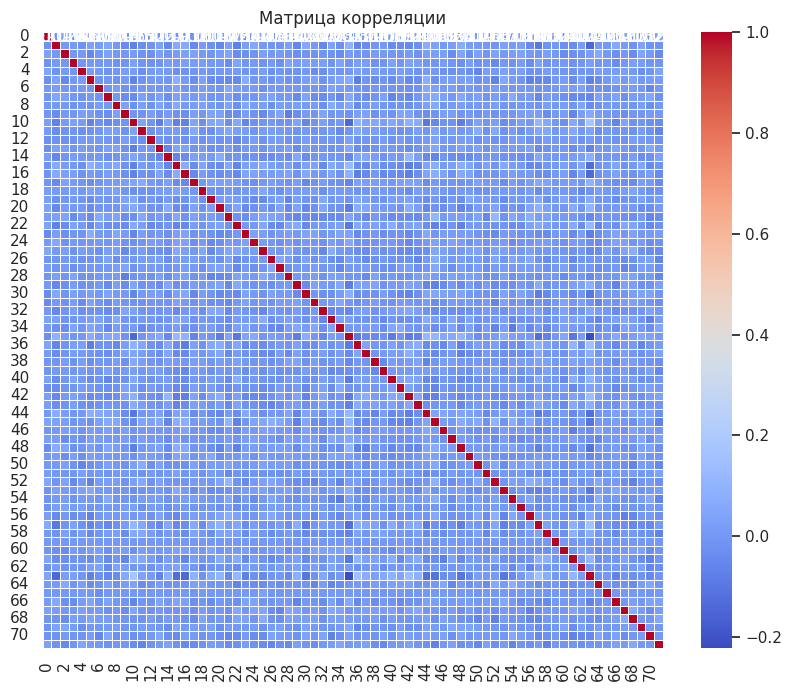

In [80]:
# Построение матрицы корреляции
corr_matrix = base.corr()

# Создание тепловой карты (heatmap) с помощью seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Матрица корреляции')
plt.show()

# ▶Перейдем к train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

In [81]:
train = pd.read_csv('/home/anna/Masterskaya2/train.csv',index_col=0)

In [82]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

Кол-во столбцов увеличилось на 1 и это целевой признак. Так же проведем предработку, хоть нам у нас есть информация, что данные схожи с base.

In [83]:
train.dtypes.value_counts()

float64    72
object      1
dtype: int64

In [84]:

train_targets = train["Target"]

train.drop("Target", axis=1, inplace=True)

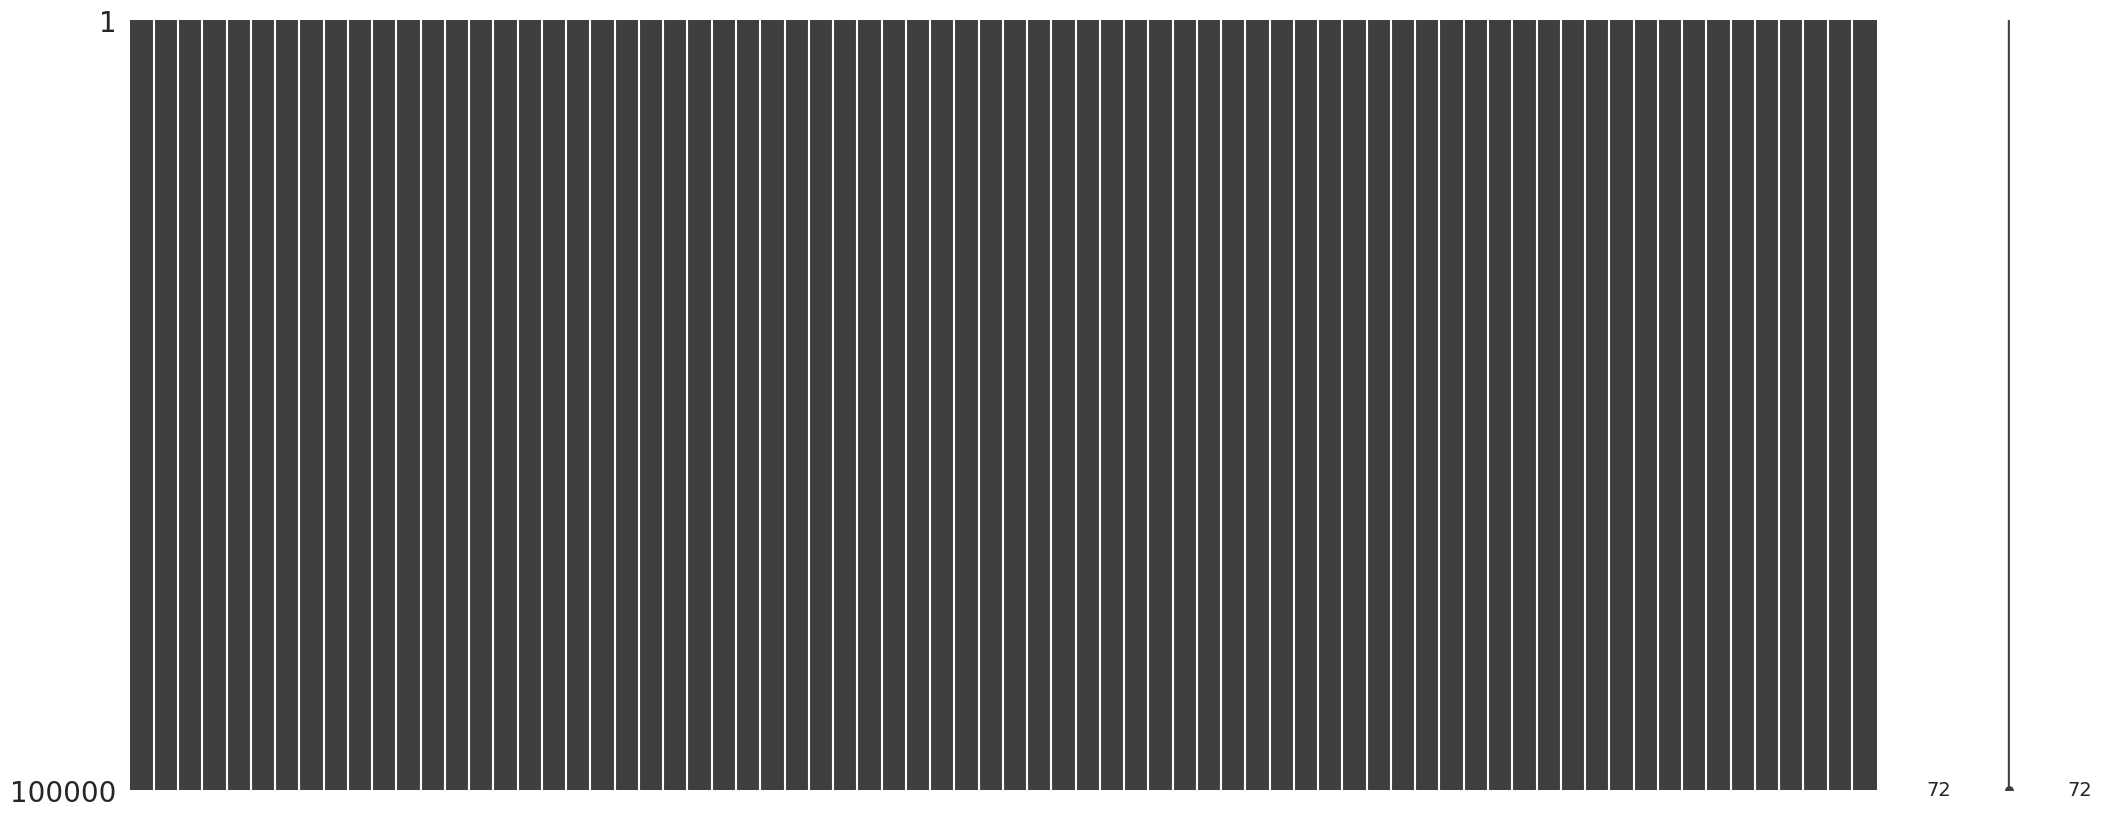

In [85]:
msno.matrix(train);

In [86]:
train[train.duplicated()]

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,


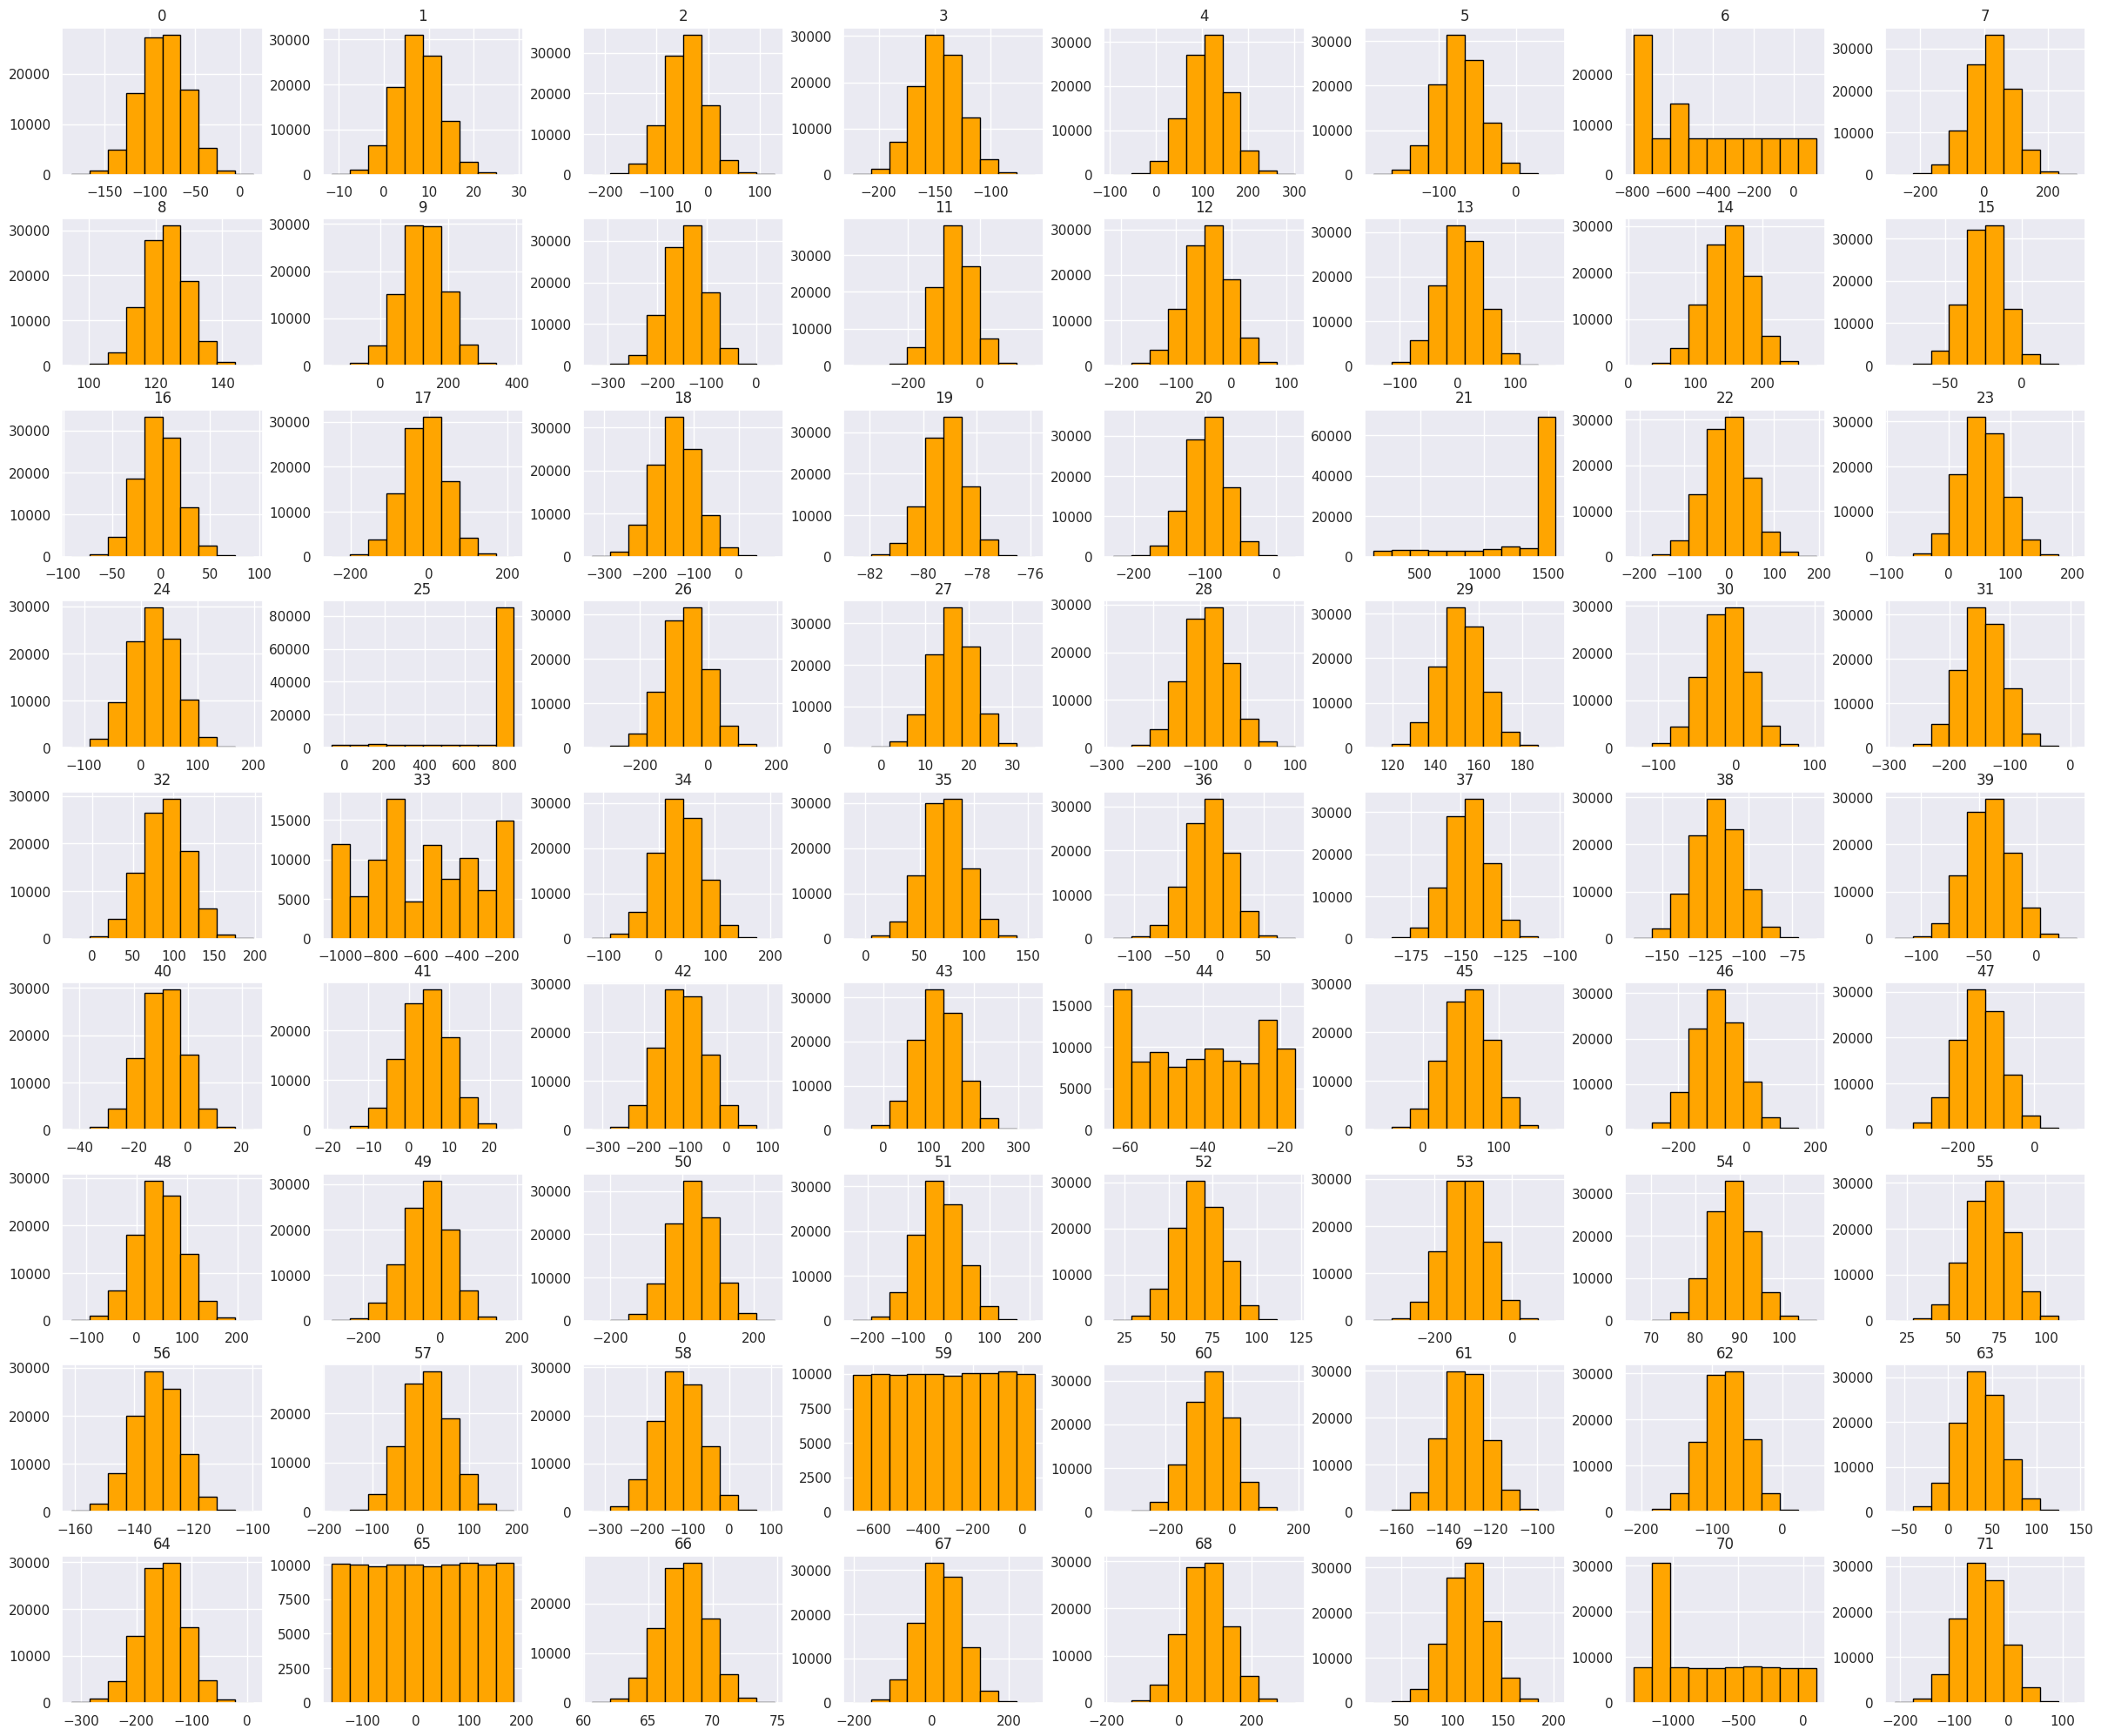

In [87]:
train.hist(figsize = (30,25),color = 'orange', edgecolor = 'black'); 

# ▶validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

In [88]:
validation = pd.read_csv('/home/anna/Masterskaya2/validation.csv',index_col=0)

In [89]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21

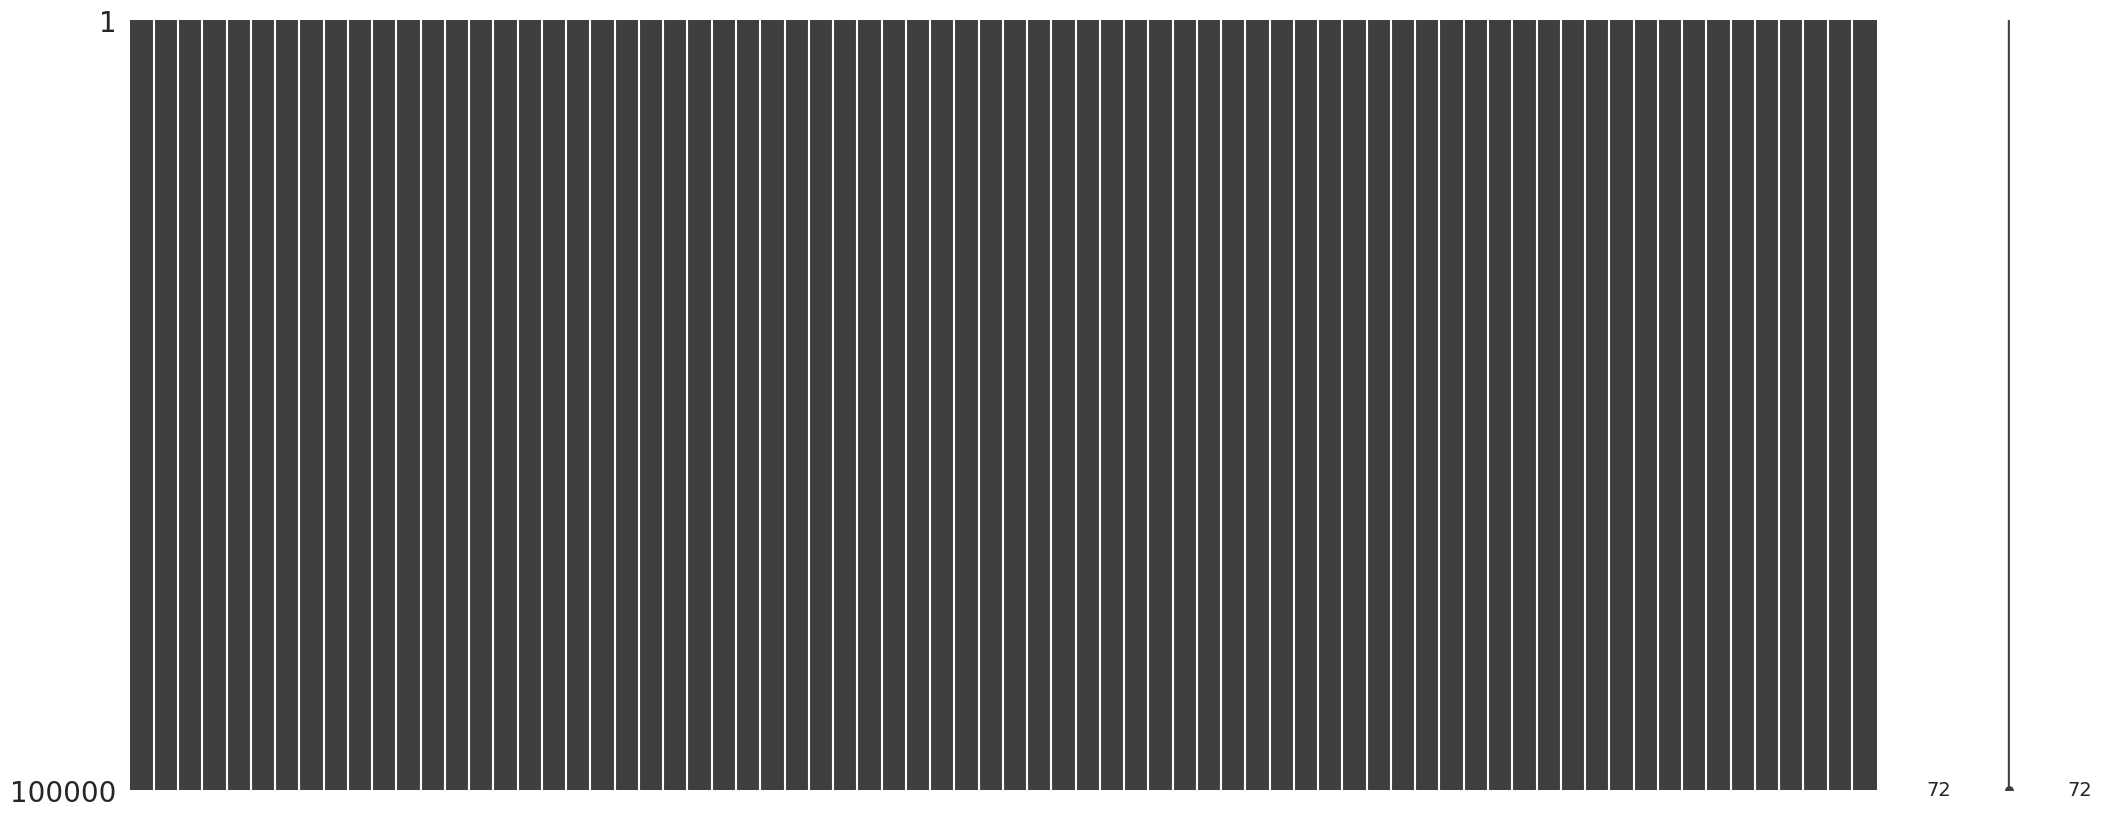

In [90]:
msno.matrix(validation);

In [91]:
validation[validation.duplicated()]

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,


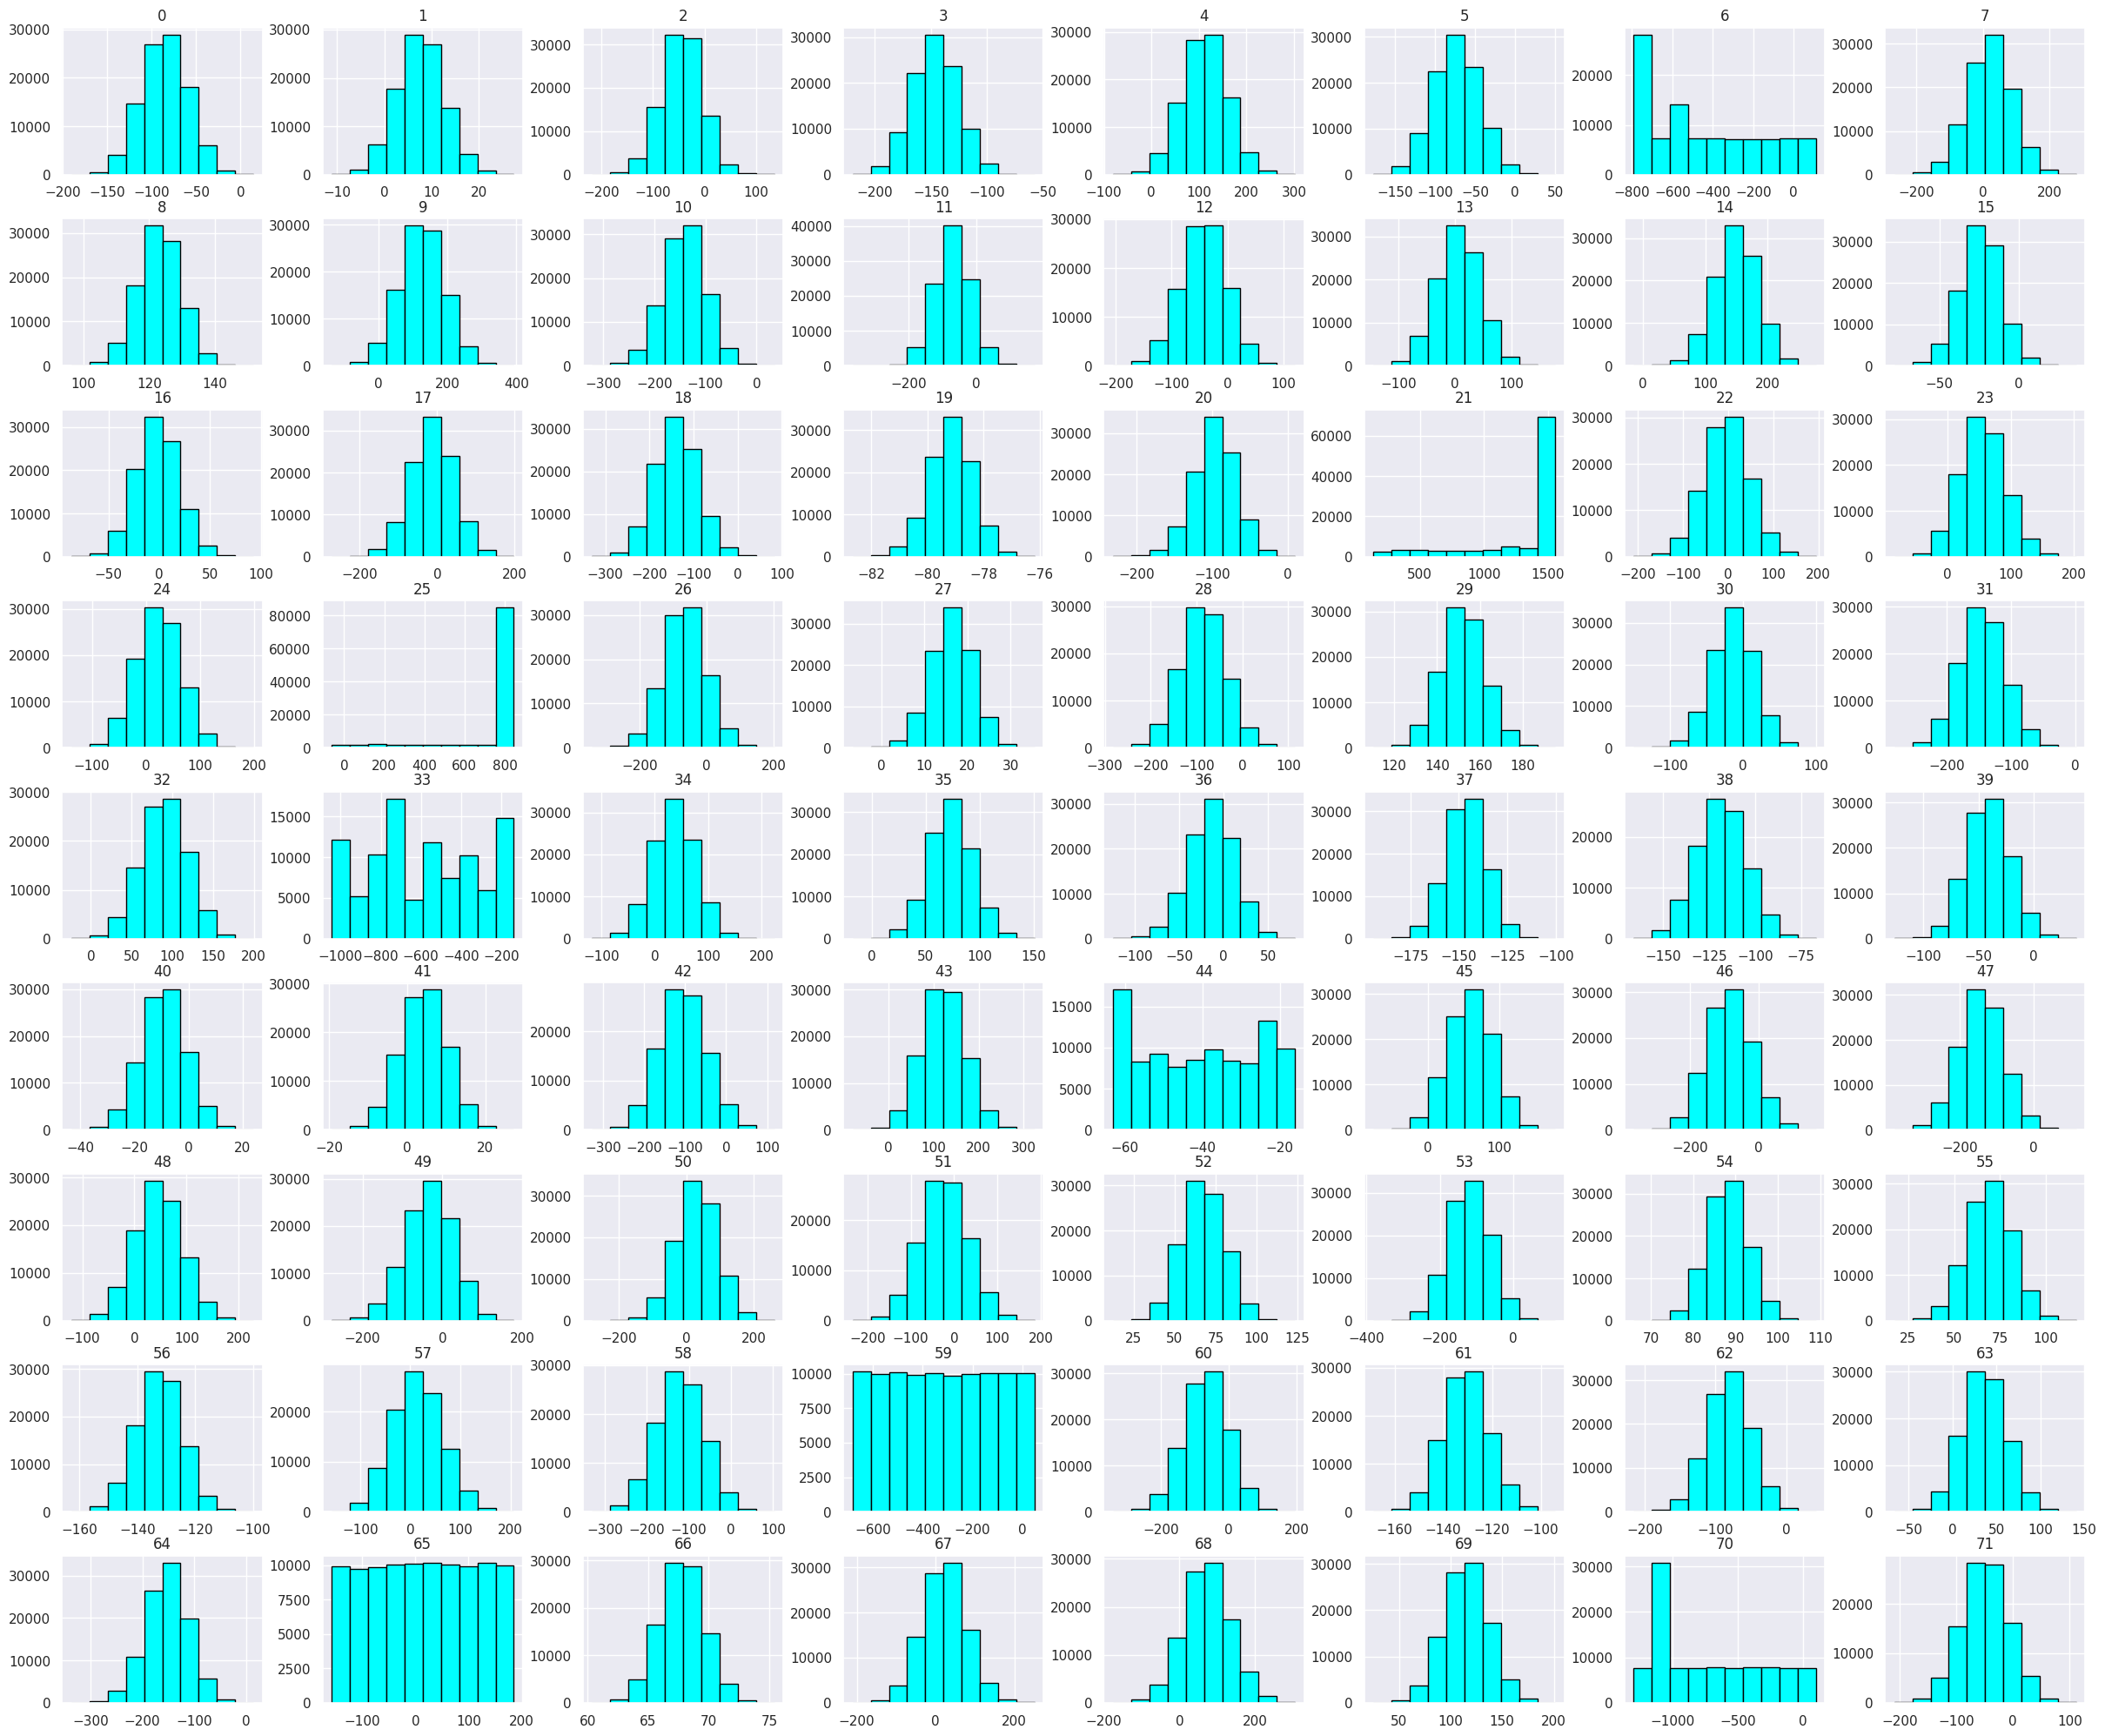

In [92]:
validation.hist(figsize = (30,25),color = 'cyan', edgecolor = 'black'); 

Общий вывод:
<br><br>1) В нашем распоряжении 3 таблицы с данными : 
 - 1.1 base Набор данных состоит из практически из 3х млн записей ( анонимные )
 - 1.2 train Обучающая выборка состоящая из 100 тыс записей 
 - 1.3 validation датасет с товарами  для которых надо найти наиболее близкие товары из base.csv
 
<br><br>2) 72 столбца. Пропуски дубликаты отсутствуют.
<br><br>3) Признаки 6, 21, 25, 33, 44, 59, 65, 70 имеют ненормальное распределение. Остальные признаки имеют распределения приближенные к нормальному.
<br><br>4) Признаки 33, 44 умеют 1-2 иникальных процента%. Можем предположить, что они категориальны.
<br><br>5) Корреляция признаков отсутствует.

# ▶validation_answer правильные ответы к validation.csv

In [93]:
validation_answer = pd.read_csv('/home/anna/Masterskaya2/validation_answer.csv')

In [94]:
validation_answer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Id        100000 non-null  object
 1   Expected  100000 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [95]:
validation_answer.head()

,Id,Expected
0,100000-query,2676668-base
1,100001-query,91606-base
2,100002-query,472256-base
3,100003-query,3168654-base
4,100004-query,75484-base


In [96]:
validation_answer.duplicated().sum()

0

In [97]:
base.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,...,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.622947e+01,8.080077e+00,-4.458080e+01,-1.466350e+02,1.113166e+02,-7.199138e+01,-3.922239e+02,2.035283e+01,1.236842e+02,1.244581e+02,...,-7.902286e+01,3.329735e+01,-1.547962e+02,1.415132e+01,6.779167e+01,2.354490e+01,7.495930e+01,1.155667e+02,-7.993390e+02,-4.779125e+01
std,2.489132e+01,4.953387e+00,3.863166e+01,1.984480e+01,4.634809e+01,2.818607e+01,2.716550e+02,6.421638e+01,6.356109e+00,6.443058e+01,...,3.045642e+01,2.888603e+01,4.122929e+01,9.895115e+01,1.823356e+00,5.534224e+01,6.134500e+01,2.117518e+01,3.854131e+02,4.174802e+01
min,-1.994687e+02,-1.391461e+01,-2.400734e+02,-2.326671e+02,-1.055830e+02,-2.110086e+02,-7.914699e+02,-3.018597e+02,9.315305e+01,-1.738719e+02,...,-2.205662e+02,-8.850774e+01,-3.539028e+02,-1.575944e+02,5.950944e+01,-2.331382e+02,-2.036016e+02,1.572448e+01,-1.297931e+03,-2.267801e+02
25%,-1.030654e+02,4.708491e+00,-6.955949e+01,-1.599051e+02,8.050795e+01,-9.137994e+01,-6.293318e+02,-2.222147e+01,1.194840e+02,8.176751e+01,...,-9.876390e+01,1.698862e+01,-1.807799e+02,-7.130038e+01,6.658096e+01,-1.251624e+01,3.377574e+01,1.016867e+02,-1.074465e+03,-7.566641e+01
50%,-8.623150e+01,8.038950e+00,-4.381661e+01,-1.467768e+02,1.118730e+02,-7.192230e+01,-4.222016e+02,2.080477e+01,1.238923e+02,1.234977e+02,...,-7.848812e+01,3.471502e+01,-1.539773e+02,1.382693e+01,6.781458e+01,2.341649e+01,7.492997e+01,1.160244e+02,-1.074465e+03,-4.859196e+01
75%,-6.925658e+01,1.147007e+01,-1.962527e+01,-1.333277e+02,1.423743e+02,-5.244111e+01,-1.566686e+02,6.391821e+01,1.279705e+02,1.672206e+02,...,-5.853355e+01,5.216429e+01,-1.273405e+02,9.966753e+01,6.902666e+01,5.975511e+01,1.158760e+02,1.295524e+02,-5.057445e+02,-1.971424e+01
max,2.151555e+01,2.993721e+01,1.609372e+02,-5.137478e+01,3.196645e+02,5.880624e+01,1.096325e+02,3.412282e+02,1.522612e+02,4.275421e+02,...,6.017411e+01,1.541678e+02,2.436099e+01,1.850981e+02,7.571203e+01,3.148988e+02,3.395738e+02,2.147063e+02,9.877081e+01,1.269732e+02


## 3. Базовые модели.

In [98]:
#pip install adjdatatools

In [99]:
#from adjdatatools.preprocessing import AdjustedScaler

In [100]:
#new_scaler = AdjustedScaler()



In [101]:
#new_scaler.fit(base)


In [102]:
#base= new_scaler.transform(base)

In [103]:
#base = pd.DataFrame(base)
#base.describe()

Мы не знаем, что скрывается за данными в 7 стобцах с яркимы выбросами ( предположение- популярные значения, которые нам нужны) . Если мы воспользуемся drop , это приведёт к потере информации об исследуемых объектах. Я нашла статью и метод нормализации данных не теряя сути данных и не сдвигая их в большую или меньшую сторону.
https://habr.com/ru/articles/527334/
https://github.com/newchronik/adjdatatools/blob/main/README.md
Не стала удалять (заккоментировала), планирую вернуться потом к данному методу и детальнее его изучить после сдачи мастерской.


Нам нужно произвести нормализацию данных, обратимся к StandardScaler(). Пробовала делать через метод  AdjustedScaler(), метрики показывают себя не лучшем образом. Закооментировала код( оставила на будущее, возмонжо можно будет что-то придумать с этим методом.)

In [104]:
scaler = StandardScaler()
scaler.fit(base)
base_transform  = scaler.transform(base)
train_transform = scaler.transform(train)
valid_transform = scaler.transform(validation)

Попроубуем удалить ненормированные данные и посмотрим, что выйдет.

In [105]:
cols = ['6', '21', '25', '33', '44', '59', '65', '70']

In [106]:
base_drop = base.drop(cols, axis=1)
train_drop= train.drop(cols, axis=1)
validation_drop = validation.drop(cols, axis=1)

In [107]:


# словарь id и номеров векторов
base_index = {k: v for k, v in enumerate(base.index.to_list())}


## 4. Вычисление оптимальных параметров для модели.

Мы используем индексный тип IndexIVFFlat для наших векторов. «Плоский» здесь означает, что векторы хранятся как есть, без какого-либо сжатия или квантования
Индекс принимает два параметра:

    n_cells указать количество кластеров, которые должны быть сформированы
    quantizer: для присвоения векторов определенному кластеру. Обычно это еще один индекс, который использует метрику расстояния L2 (мы используем индекс FlatL2).

### 1 вариант.

In [108]:


dims = base_transform.shape[1] # n-мерность векторов
n_cells = 100 # взяли 100 кластеров 
n_probe = 50 # 50 соседних

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
idx_l2.nprobe = n_probe
# инициализация индекса

In [109]:


#подготовка к поиску
idx_l2.train(np.ascontiguousarray(base_transform).astype('float32'))

# деление всех векторов по правилам, сформированным на предыдущем шаге 
idx_l2.add(np.ascontiguousarray(base_transform).astype('float32'))



In [110]:
neighbor = 5 # 5 соседей

distance, train_idx = idx_l2.search(np.ascontiguousarray(train_transform).astype('float32'), neighbor) 
print('Примеры train_idx :\n', train_idx[:3], '\n')
print('Примеры vectors :\n', distance[:3])
del distance


Примеры train_idx :
 [[ 598613  755584  336969 1934845   13374]
 [ 737853   15185  519311  902634  223456]
 [ 173120 1784963 2863071 1143288  955831]] 

Примеры vectors :
 [[19.29954  19.4676   20.747215 23.199968 23.545162]
 [22.419256 24.467981 25.589373 28.398129 30.44619 ]
 [18.721733 22.402527 24.452156 24.944103 25.362715]]


In [111]:


# функция вычисления accuracy@n
def accuracy_n(targets, predict, base_index=base_index):
    acc = 0
    for target, candidates in zip(targets.tolist(), predict.tolist()):
        acc += int(target in [base_index[number] for number in candidates])

    return (acc / len(predict) * 100)



In [112]:
print(f"Метрика accuracy@5 на модели c {n_cells} кластеров и поиском по {neighbor} соседним = {accuracy_n(train_targets, train_idx)}")


Метрика accuracy@5 на модели c 100 кластеров и поиском по 5 соседним = 65.81


### 2 вариант.

In [113]:
dims = base_transform.shape[1] # n-мерность векторов
n_cells = 50 # взяли 50 кластеров 
n_probe = 25 # 25 соседних

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
idx_l2.nprobe = n_probe
# инициализация индекса

In [114]:

#подготовка к поиску
idx_l2.train(np.ascontiguousarray(base_transform).astype('float32'))

# деление всех векторов по правилам, сформированным на предыдущем шаге 
idx_l2.add(np.ascontiguousarray(base_transform).astype('float32'))

In [115]:
neighbor = 5 # 5 соседей

distance, train_idx = idx_l2.search(np.ascontiguousarray(train_transform).astype('float32'), neighbor) 

In [116]:

# функция вычисления accuracy@n
def accuracy_n(targets, predict, base_index=base_index):
    acc = 0
    for target, candidates in zip(targets.tolist(), predict.tolist()):
        acc += int(target in [base_index[number] for number in candidates])

    return (acc / len(predict) * 100)

In [117]:
print(f"Метрика accuracy@5 на модели c {n_cells} кластеров и поиском по {n_probe} соседним = {accuracy_n(train_targets, train_idx)}")

Метрика accuracy@5 на модели c 50 кластеров и поиском по 25 соседним = 65.771


### 3 вариант.

In [118]:
dims = base_transform.shape[1] # n-мерность векторов
n_cells = 250 # взяли 250 кластеров 
n_probe = 100

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

idx_l2.nprobe = n_probe

In [119]:

#подготовка к поиску
idx_l2.train(np.ascontiguousarray(base_transform).astype('float32'))

# деление всех векторов по правилам, сформированным на предыдущем шаге 
idx_l2.add(np.ascontiguousarray(base_transform).astype('float32'))



idx_l2.is_trained

True

In [120]:
neighbor = 5 # 5 соседей

distance, train_idx = idx_l2.search(np.ascontiguousarray(train_transform).astype('float32'), neighbor) 

In [121]:
# функция вычисления accuracy@n
def accuracy_n(targets, predict, base_index=base_index):
    acc = 0
    for target, candidates in zip(targets.tolist(), predict.tolist()):
        acc += int(target in [base_index[number] for number in candidates])

    return (acc / len(predict) * 100)


In [122]:
print(f"Метрика accuracy@5 на модели c {n_cells} кластеров и поиском по {n_probe} соседним = {accuracy_n(train_targets, train_idx)}")

Метрика accuracy@5 на модели c 250 кластеров и поиском по 100 соседним = 65.789


## А теперь посмотрим как метрика среагирует , если мы уберем ненормированные признаки. 

In [123]:
scaler = StandardScaler()
scaler.fit(base_drop)
base_transform_drop  = scaler.transform(base_drop)
train_transform_drop = scaler.transform(train_drop)
valid_transform_drop = scaler.transform(validation_drop)

In [124]:
# словарь id и номеров векторов
base_index = {k: v for k, v in enumerate(base_drop.index.to_list())}


In [125]:
dims = base_transform_drop.shape[1] # n-мерность векторов
n_cells = 100 # взяли 100 кластеров 
n_probe = 50 # по 150 соседним 

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

idx_l2.nprobe = n_probe

In [126]:
#подготовка к поиску
idx_l2.train(np.ascontiguousarray(base_transform_drop).astype('float32'))

# деление всех векторов по правилам, сформированным на предыдущем шаге 
idx_l2.add(np.ascontiguousarray(base_transform_drop).astype('float32'))



idx_l2.is_trained

True

In [127]:
neighbor = 5 # 5 соседей

distance, train_idx = idx_l2.search(np.ascontiguousarray(train_transform_drop).astype('float32'), neighbor) 

In [128]:
# функция вычисления accuracy@n
def accuracy_n(targets, predict, base_index=base_index):
    acc = 0
    for target, candidates in zip(targets.tolist(), predict.tolist()):
        acc += int(target in [base_index[number] for number in candidates])

    return (acc / len(predict) * 100)

In [129]:
print(f"Метрика accuracy@5 на модели c {n_cells} кластеров и поиском по {n_probe} соседним = {accuracy_n(train_targets, train_idx)}")

Метрика accuracy@5 на модели c 100 кластеров и поиском по 50 соседним = 71.02199999999999


Достаточно хорошая метрика у нас получилась, когда мы избавились от ненормированных признаков.Теперь протестируем это на валидации.

## 5. Тест параметров на валидационной выборке.

In [130]:
# словарь id и номеров векторов
base_index = {k: v for k, v in enumerate(base_drop.index.to_list())}

In [131]:
dims = base_transform_drop.shape[1] # n-мерность векторов
n_cells = 100 # взяли 100 кластеров 
n_probe = 50 # по 50 соседним 

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

idx_l2.nprobe = n_probe

In [132]:
#подготовка к поиску
idx_l2.train(np.ascontiguousarray(base_transform_drop).astype('float32'))

# деление всех векторов по правилам, сформированным на предыдущем шаге 
idx_l2.add(np.ascontiguousarray(base_transform_drop).astype('float32'))



idx_l2.is_trained

True

In [133]:
neighbor = 5 # 5 соседей

distance, valid_idx = idx_l2.search(np.ascontiguousarray(valid_transform_drop).astype('float32'), neighbor) 

In [134]:
# функция вычисления accuracy@n
def accuracy_n(targets, predict, base_index=base_index):
    acc = 0
    for target, candidates in zip(targets.tolist(), predict.tolist()):
        acc += int(target in [base_index[number] for number in candidates])

    return (acc / len(predict) * 100)

In [135]:
print('accuracy@{} на валидационной выборке: {:.2f}%'.format(neighbor, accuracy_n(validation_answer['Expected'], valid_idx)))

accuracy@5 на валидационной выборке: 70.91%


# Общий вывод.
## Результат работы.
  - Значение целевой метрики `accuracy@5` 70.91 было достигнуто с использованием модели `FAISS` с параметрами
    - с кол-вом кластеров 100;
    - индексом `IVFFlat`;
    - c кол-во посещаемых кластеров 50;
  - на смасштабированных с помощью `StandardScaler()` данных;
  - с удалением признаков, распределённых ненормально.

## Задача.
  - Был разработан алгоритм, который для всех товаров из `validation.csv` находит 5 похожих из `base.csv`.


## Данные.
- Размер датасетов:
  - `base`: 2918139 X 72 с идентификаторами объектов в индексе;
  - `train`: 100000 X 73, в т.ч. признак ответов, и с идентификаторами объектов в индексе;
  - `validation`: 100000 X 72 с идентификаторами объектов в индексе;
  - `validation_answers`: 100000 X 1 - признак ответов с идентификаторами объектов в индексе.
- Распределение признаков.
  - Признаки 6, 21, 25, 33, 44, 59, 65, 70 имеют ненормальное распределение. Остальные признаки имеют распределения приближенные к нормальному.Провели тест Шапиро-Уилка. <br>
  Из-за невозможности идентификации признаков признаки с ненормальным распределением были удалены.
- Выбросы / аномалии.
  - Большинство признаков имеют нормальное распределеделение.
  - Дубликаты отсутствуют.
- Признаки 33 и 44 возможно категориальны, т.к. имеют менее 1% и 2% уникальнах значений соответственно. 
- Корреляция признаков не обнаружена.
